<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
import numpy as np


In [22]:

# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
#x_train = (x_train.astype("float32") - 127.5) / 127.5
#y_train = y_train.reshape(-1, 1)
x_train = (x_train.astype("float32")) / np.max(x_train)

print(y_train)


[5 0 4 ... 5 6 8]


In [23]:
print(np.max(x_train))

1.0


In [24]:
x_train2 = x_train[:100]
y_train2 = y_train[:100]

In [25]:
class CustomFullAug(tf.keras.layers.Layer):
    def __init__(self, probability=.2,rot_factor=.2,height=.2,width=.2,stdev=.2):
        super(CustomFullAug, self).__init__()
        self.probability = probability

        self.rot_factor = rot_factor
        self.height = height
        self.width = width
        self.stdev = stdev
        self.flip_layer = tf.keras.layers.RandomFlip()
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=rot_factor)
        self.noise_layer = tf.keras.layers.GaussianNoise(stddev = stdev)


    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            flipped_data = self.flip_layer(inputs, training=training)
            rotated_data = self.rotation_layer(flipped_data, training=training)
            zoomed_data = self.zoom_layer(rotated_data, training=training)
            noised = self.noise_layer(zoomed_data, training=training)
            return noised
        else:
            return inputs

In [26]:

class CustomFlipLayer(tf.keras.layers.Layer):
    def __init__(self, probability):
        super(CustomFlipLayer, self).__init__()
        self.probability = probability
        self.flip_layer = tf.keras.layers.RandomFlip()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            flipped_data = self.flip_layer(inputs, training=training)
            return flipped_data
        else:
            return inputs

In [27]:
class CustomRotationLayer(tf.keras.layers.Layer):
    def __init__(self, probability, factor):
        super(CustomRotationLayer, self).__init__()
        self.probability = probability
        self.factor = factor
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=factor)

    def call(self, inputs, training=True):
        if tf.random.uniform(()) < self.probability:
            rotated_data = self.rotation_layer(inputs, training=training)
            return rotated_data
        else:
            return inputs

In [28]:
class CustomZoomLayer(tf.keras.layers.Layer):
    def __init__(self, probability,height, width):
        super(CustomZoomLayer, self).__init__()
        self.probability = probability
        self.height = height
        self.width = width
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)

    def call(self, inputs, training=False):
        if tf.random.uniform(()) < self.probability:
            zoomed_data = self.zoom_layer(inputs, training=training)
            return zoomed_data
        else:
            return inputs

In [33]:


def build_generator():
    noise_shape = (28,28,1)
    noise = layers.Input(shape=noise_shape)
    noise_reshaped = layers.MaxPooling2D(strides=2)(noise)
    noise_reshaped = layers.MaxPooling2D(strides=2)(noise_reshaped)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 7*7)(input_digit)
    digit_embedding = layers.Reshape((7, 7, 1))(digit_embedding)


    #noise = layers.Reshape((28, 28, 1))(noise)

    x = layers.Concatenate()([noise_reshaped, digit_embedding])
    #x = layers.Conv2D(256, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    #x = layers.Conv2D(256, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(1, 2, strides=2, padding="same", activation="tanh")(x)

    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=x)
    return model

generator = build_generator()
generator.summary()



Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 14, 14, 1)   0           ['input_30[0][0]']               
 )                                                                                                
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 49)        490         ['input_31[0][0]']         

In [34]:
def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,), dtype="int32")
    #digit_embedding = layers.Embedding(10,10)(digit_input)
    #digit_embedding = layers.Flatten()(digit_embedding)

    digit_embedding_2d = layers.Embedding(10, 28*28)(digit_input)
    digit_emb_skip = layers.Embedding(10, 10)(digit_input)
    digit_embedding_2d = layers.Reshape((28, 28, 1))(digit_embedding_2d)

    #rescaling_layer = layers.Rescaling(scale=1/2, offset=0.5)(input_image)
    #lip = CustomFlipLayer(.4)(input_image)
    #rotate = CustomRotationLayer(.4,.2)(flip)
    #zoom = CustomZoomLayer(.2,.2,.2)(rotate)

    fullLayt = CustomFullAug(probability=.1,stdev=.1)(input_image)

    merged_input = layers.Concatenate()([fullLayt, digit_embedding_2d])

    x = layers.Conv2D(64, 2, strides=1, padding="same", activation="relu")(merged_input)
    x = layers.Conv2D(128, 2, strides=1, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 2, strides=2, padding="same", activation="relu")(x)


    x = layers.Flatten()(x)
    x = layers.Dense(200)(x)
    x = layers.Dense(100)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 784)       7840        ['input_33[0][0]']               
                                                                                                  
 custom_full_aug_2 (CustomFullA  (None, 28, 28, 1)   0           ['input_32[0][0]']               
 ug)                                                                                        

In [35]:
# Define the GAN model
def build_gan(generator, discriminator):
    noise_shape = (28,28,1)
    digit_shape = (1,)
    noise = layers.Input(shape=noise_shape)
    digit = layers.Input(shape=digit_shape)

    generated_image = generator([noise, digit])

    discriminator_output = discriminator([generated_image, digit])
    model = tf.keras.models.Model(inputs=[noise, digit], outputs=discriminator_output)
    return model

gan = build_gan(generator, discriminator)
gan.summary()




Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_8 (Functional)           (None, 28, 28, 1)    1323        ['input_34[0][0]',               
                                                                  'input_35[0][0]']               
                                                                                                  
 model_9 (Functional)           (None, 1)            1143569     ['model_8[0][0]',         

In [36]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [37]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



Epoch 5/20000
1/1 [==============================] - 0s 140ms/step


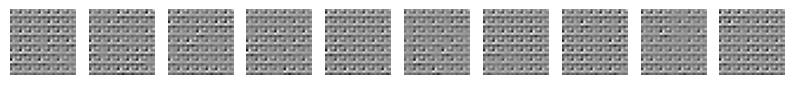

Epoch 10/20000
1/1 [==============================] - 0s 64ms/step


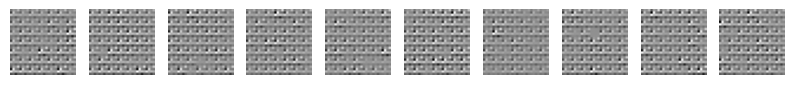

Epoch 15/20000
1/1 [==============================] - 0s 27ms/step


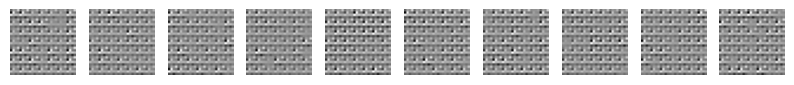

Epoch 20/20000
1/1 [==============================] - 0s 42ms/step


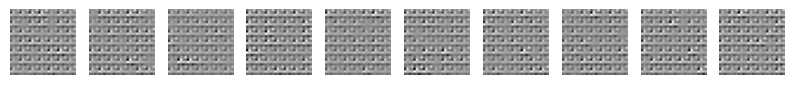

Epoch 25/20000
1/1 [==============================] - 0s 34ms/step


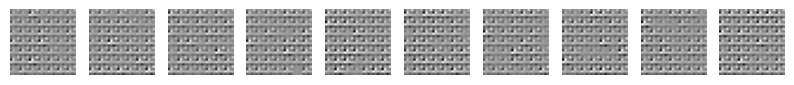

Epoch 30/20000
1/1 [==============================] - 0s 31ms/step


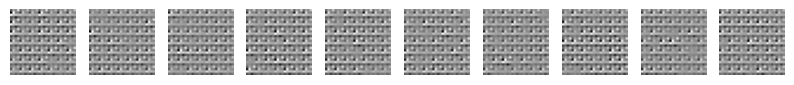

Epoch 35/20000
1/1 [==============================] - 0s 30ms/step


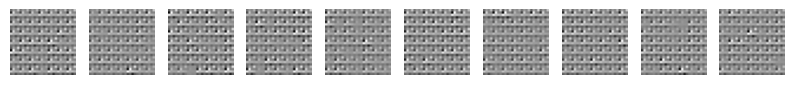

Epoch 40/20000
1/1 [==============================] - 0s 31ms/step


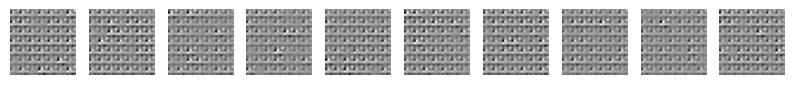

Epoch 45/20000
1/1 [==============================] - 0s 32ms/step


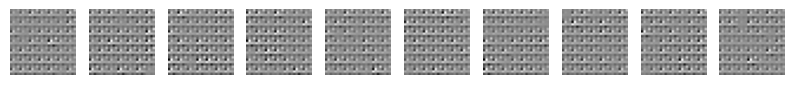

Epoch 50/20000
1/1 [==============================] - 0s 29ms/step


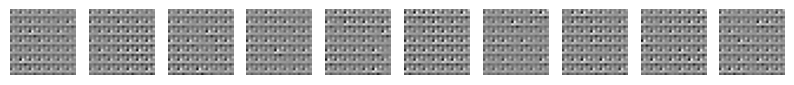

Epoch 55/20000
1/1 [==============================] - 0s 30ms/step


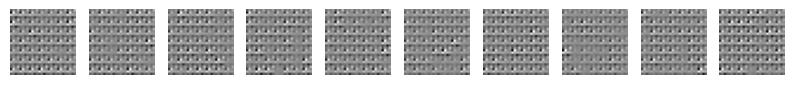

Epoch 60/20000
1/1 [==============================] - 0s 30ms/step


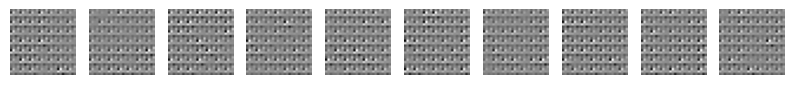

Epoch 65/20000
1/1 [==============================] - 0s 31ms/step


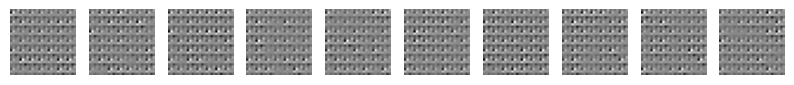

Epoch 70/20000
1/1 [==============================] - 0s 39ms/step


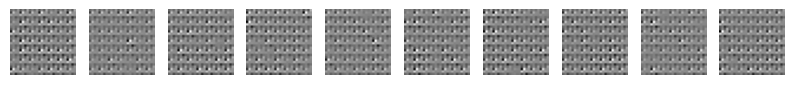

Epoch 75/20000
1/1 [==============================] - 0s 48ms/step


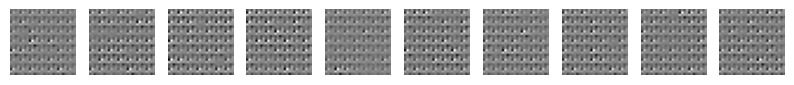

Epoch 80/20000
1/1 [==============================] - 0s 28ms/step


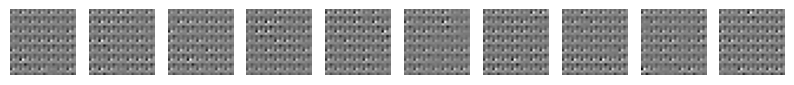

Epoch 85/20000
1/1 [==============================] - 0s 28ms/step


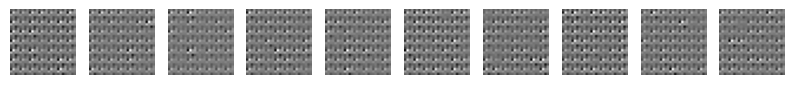

Epoch 90/20000
1/1 [==============================] - 0s 27ms/step


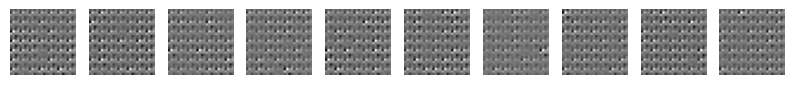

Epoch 95/20000
1/1 [==============================] - 0s 26ms/step


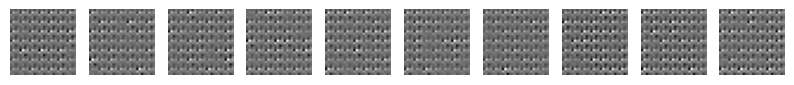

Epoch 100/20000
1/1 [==============================] - 0s 27ms/step


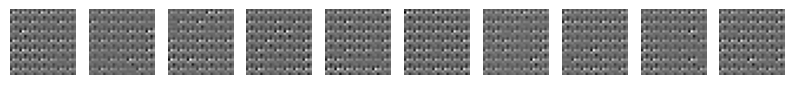

Epoch 105/20000
1/1 [==============================] - 0s 29ms/step


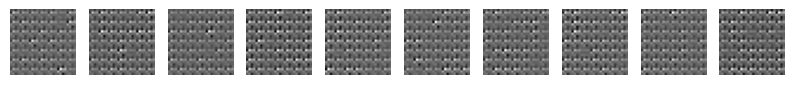

Epoch 110/20000
1/1 [==============================] - 0s 35ms/step


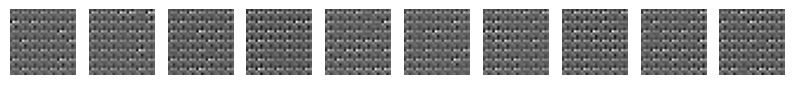

Epoch 115/20000
1/1 [==============================] - 0s 26ms/step


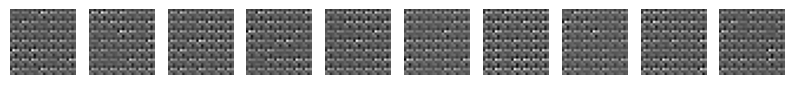

Epoch 120/20000
1/1 [==============================] - 0s 30ms/step


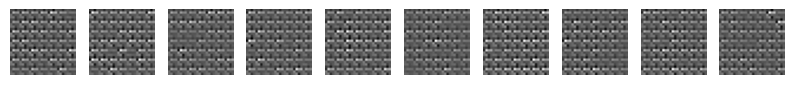

Epoch 125/20000
1/1 [==============================] - 0s 28ms/step


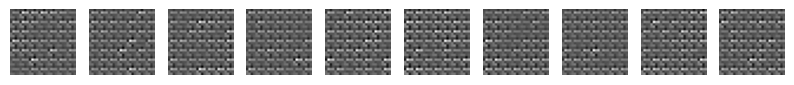

Epoch 130/20000
1/1 [==============================] - 0s 27ms/step


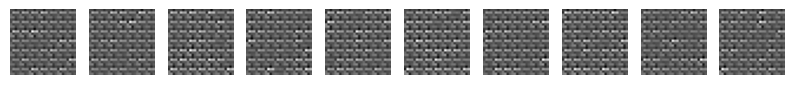

Epoch 135/20000
1/1 [==============================] - 0s 28ms/step


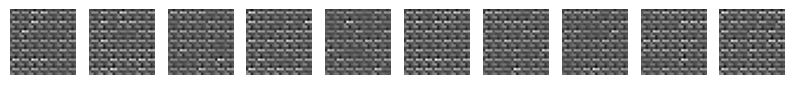

Epoch 140/20000
1/1 [==============================] - 0s 36ms/step


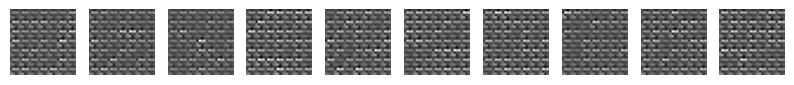

Epoch 145/20000
1/1 [==============================] - 0s 34ms/step


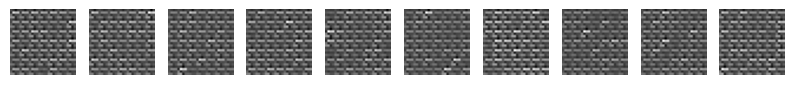

Epoch 150/20000
1/1 [==============================] - 0s 29ms/step


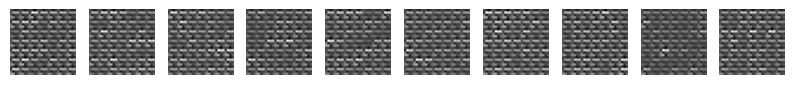

Epoch 155/20000
1/1 [==============================] - 0s 31ms/step


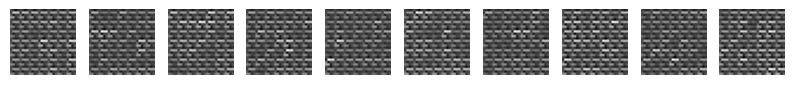

Epoch 160/20000
1/1 [==============================] - 0s 41ms/step


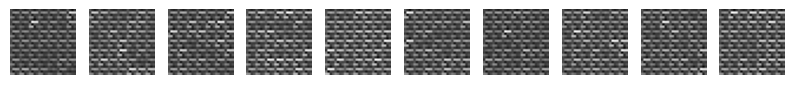

Epoch 165/20000
1/1 [==============================] - 0s 27ms/step


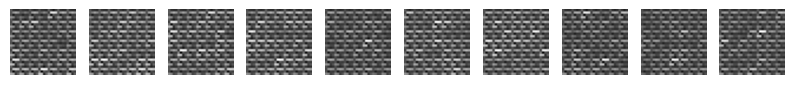

Epoch 170/20000
1/1 [==============================] - 0s 39ms/step


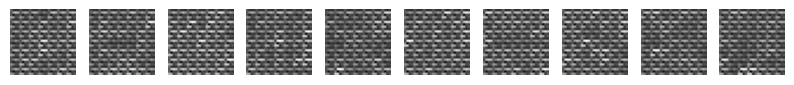

Epoch 175/20000
1/1 [==============================] - 0s 32ms/step


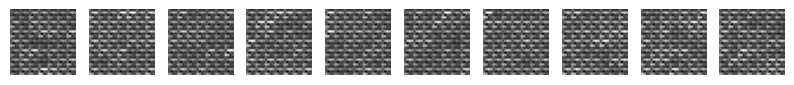

Epoch 180/20000
1/1 [==============================] - 0s 65ms/step


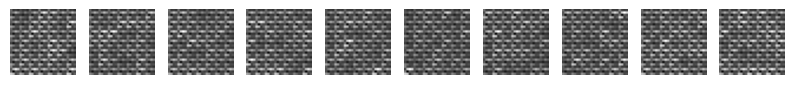

Epoch 185/20000
1/1 [==============================] - 0s 30ms/step


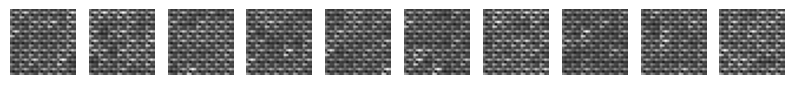

Epoch 190/20000
1/1 [==============================] - 0s 49ms/step


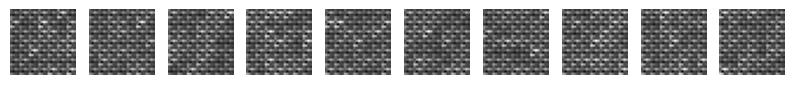

Epoch 195/20000
1/1 [==============================] - 0s 31ms/step


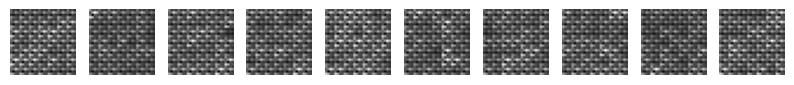

Epoch 200/20000
1/1 [==============================] - 0s 29ms/step


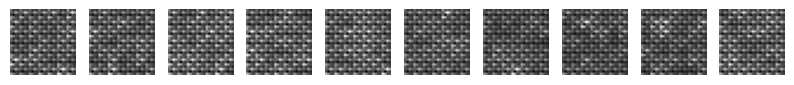

Epoch 205/20000
1/1 [==============================] - 0s 28ms/step


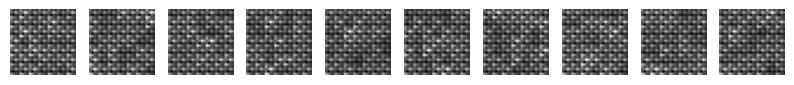

Epoch 210/20000
1/1 [==============================] - 0s 31ms/step


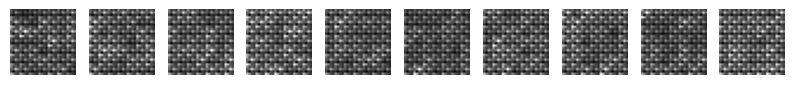

Epoch 215/20000
1/1 [==============================] - 0s 29ms/step


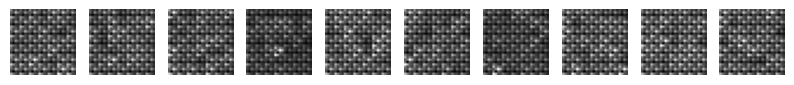

Epoch 220/20000
1/1 [==============================] - 0s 25ms/step


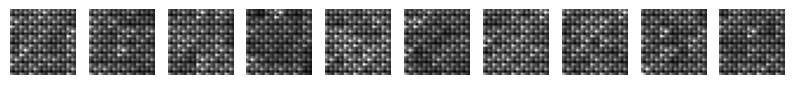

Epoch 225/20000
1/1 [==============================] - 0s 31ms/step


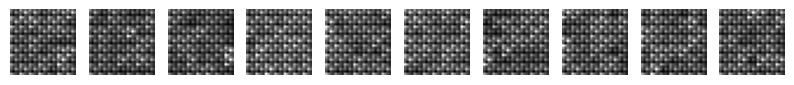

Epoch 230/20000
1/1 [==============================] - 0s 29ms/step


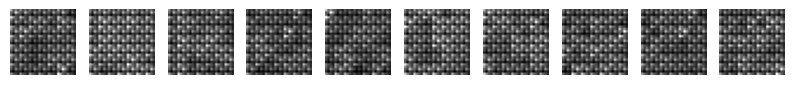

Epoch 235/20000
1/1 [==============================] - 0s 30ms/step


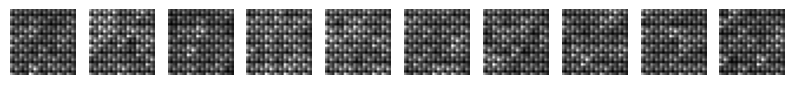

Epoch 240/20000
1/1 [==============================] - 0s 26ms/step


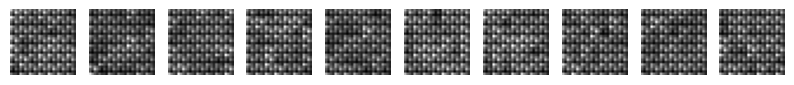

Epoch 245/20000
1/1 [==============================] - 0s 30ms/step


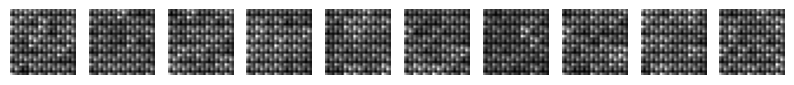

Epoch 250/20000
1/1 [==============================] - 0s 31ms/step


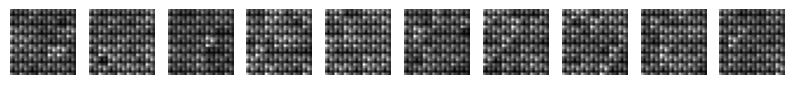

Epoch 255/20000
1/1 [==============================] - 0s 25ms/step


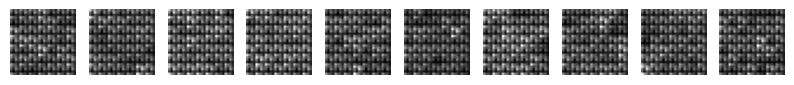

Epoch 260/20000
1/1 [==============================] - 0s 26ms/step


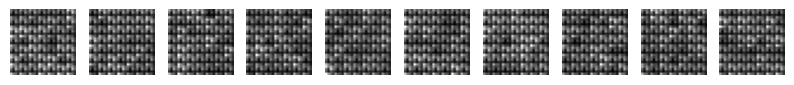

Epoch 265/20000
1/1 [==============================] - 0s 39ms/step


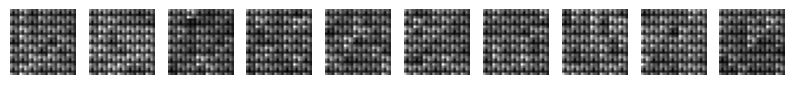

Epoch 270/20000
1/1 [==============================] - 0s 28ms/step


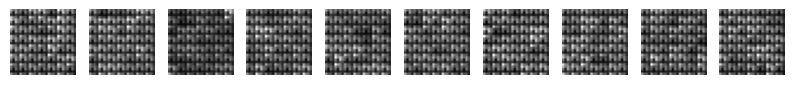

Epoch 275/20000
1/1 [==============================] - 0s 44ms/step


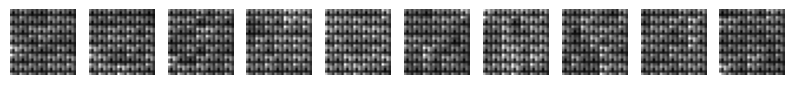

Epoch 280/20000
1/1 [==============================] - 0s 30ms/step


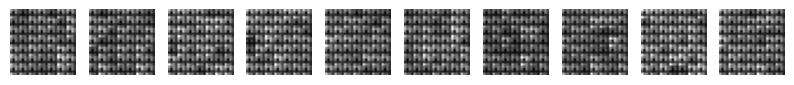

Epoch 285/20000
1/1 [==============================] - 0s 41ms/step


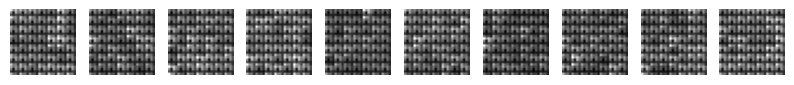

Epoch 290/20000
1/1 [==============================] - 0s 26ms/step


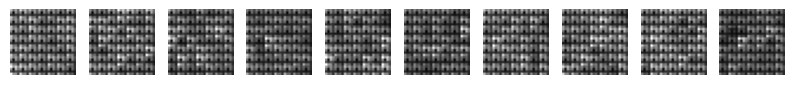

Epoch 295/20000
1/1 [==============================] - 0s 28ms/step


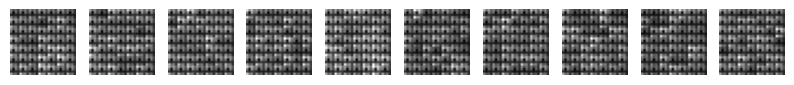

KeyboardInterrupt: ignored

In [38]:


@tf.function
def train_step(images, labels):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 28,28,1])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(generator, discriminator, gan, epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(x_train2) // batch_size):
            images = x_train2[batch * batch_size: (batch+1) * batch_size]
            labels = y_train2[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            # Generate and save sample images
            noise = tf.random.normal([10, 28,28,1])
            sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
            generated_images = generator.predict([noise, sampled_labels])
            generated_images = generated_images#(generated_images * 0.5) + 0.5  # Rescale images from [-1, 1] to [0, 1]
            fig, axs = plt.subplots(1, 10, figsize=(10, 10))
            for i in range(10):
                axs[i].imshow(generated_images[i], cmap="gray")
                axs[i].axis("off")
            plt.show()

# Train the GAN
EPOCHS = 20000
BATCH_SIZE = 64
train(generator, discriminator, gan, EPOCHS, BATCH_SIZE)